In [2]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np


d:\Project-to-learn\.env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Choose Model

In [3]:
model_name='bert-base-uncased'
tokenizer= AutoTokenizer.from_pretrained(model_name)
model=AutoModel.from_pretrained(model_name)  #returns last_hidden_state and pooler by default

In [5]:
sentences = [
    "I love machine learning.",
    "I love machine learning models.",
    "I love learning.",
    "Playing with transformers is fun."
]

 4) Tokenize with padding + return offsets

In [6]:
encoded=tokenizer(sentences, padding=True, return_tensors="pt",return_attention_mask=True,return_offsets_mapping=True)
print(encoded)

{'input_ids': tensor([[  101,  1045,  2293,  3698,  4083,  1012,   102,     0],
        [  101,  1045,  2293,  3698,  4083,  4275,  1012,   102],
        [  101,  1045,  2293,  4083,  1012,   102,     0,     0],
        [  101,  2652,  2007, 19081,  2003,  4569,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1]]), 'offset_mapping': tensor([[[ 0,  0],
         [ 0,  1],
         [ 2,  6],
         [ 7, 14],
         [15, 23],
         [23, 24],
         [ 0,  0],
         [ 0,  0]],

        [[ 0,  0],
         [ 0,  1],
         [ 2,  6],
         [ 7, 14],
         [15, 23],
         [24, 30],
         [30, 31],
         [ 0,  0]],

        [[ 0,  0],
         [ 0,  1],
         [ 2,  6],
         [ 7, 15],
      

In [7]:
input_ids = encoded["input_ids"]            # shape: (batch, seq_len)
attention_mask = encoded["attention_mask"]  # shape: (batch, seq_len)
offsets = encoded["offset_mapping"]

In [8]:
print(input_ids.shape, attention_mask.shape, offsets.shape)

torch.Size([4, 8]) torch.Size([4, 8]) torch.Size([4, 8, 2])


In [9]:
print("Sample Token for Sentence 0",tokenizer.convert_ids_to_tokens(input_ids[0]))
print("Offsets for sentence 0",offsets[0])

Sample Token for Sentence 0 ['[CLS]', 'i', 'love', 'machine', 'learning', '.', '[SEP]', '[PAD]']
Offsets for sentence 0 tensor([[ 0,  0],
        [ 0,  1],
        [ 2,  6],
        [ 7, 14],
        [15, 23],
        [23, 24],
        [ 0,  0],
        [ 0,  0]])


5) Get model outputs (contextual embeddings)

In [10]:
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    last_hidden = outputs.last_hidden_state   # shape: (batch, seq_len, hidden_size)

In [11]:
print("Last hidden state shape:", last_hidden.shape)
# Example: token-level embedding for first token of sentence 0
token0_embed = last_hidden[0, 1, :].numpy()  # skip [CLS] at index 0
print("Token embedding vector size:", token0_embed.shape)

Last hidden state shape: torch.Size([4, 8, 768])
Token embedding vector size: (768,)


Visualize embeddings

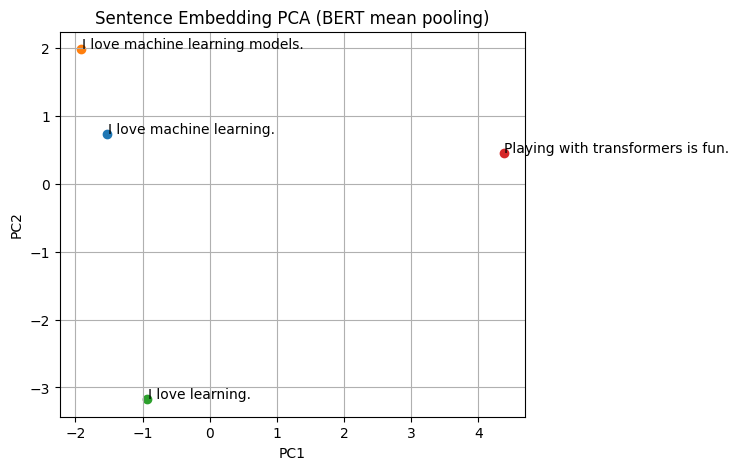

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# 1) Mean-pool token embeddings (mask-out padding)
mask = attention_mask.unsqueeze(-1).type(torch.float32)  # (batch, seq_len, 1)
masked_hidden = last_hidden * mask
sum_hidden = masked_hidden.sum(dim=1)      # sum over seq_len -> (batch, hidden)
lengths = mask.sum(dim=1)                  # (batch,1)
sentence_embeds = (sum_hidden / lengths).numpy()  # (batch, hidden)

# 2) PCA to 2D
pca = PCA(n_components=2)
proj = pca.fit_transform(sentence_embeds)

# 3) Plot
plt.figure(figsize=(6,5))
for i, txt in enumerate(sentences):
    x,y = proj[i]
    plt.scatter(x,y)
    plt.text(x+0.01, y+0.01, txt[:40])  # show short text
plt.title("Sentence Embedding PCA (BERT mean pooling)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.grid(True)
plt.show()

In [15]:
word = "transformers"
print(tokenizer.tokenize(word))
print(tokenizer(word, return_tensors="pt"))


['transformers']
{'input_ids': tensor([[  101, 19081,   102]]), 'token_type_ids': tensor([[0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1]])}


In [16]:
tokenizer.tokenize("supercalifragilisticexpialidocious")


['super',
 '##cal',
 '##if',
 '##rag',
 '##ilis',
 '##tic',
 '##ex',
 '##pia',
 '##lid',
 '##oc',
 '##ious']

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
sim = cosine_similarity(sentence_embeds)
print(sim)  # NxN matrix of similarity


[[0.9999998  0.94198716 0.87929296 0.7791583 ]
 [0.94198716 1.0000002  0.8192797  0.7399933 ]
 [0.87929296 0.8192797  1.0000001  0.75705063]
 [0.7791583  0.7399933  0.75705063 1.        ]]
